In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import cmocean
import matplotlib.ticker as mticker
from utils import move_last_two_months_first

def estimate_expected_sampling_loss(stds, n_samples):
    std = np.std(stds ** 2 / n_samples, axis=0)
    print("Maximum Standard Deviation of Variance: {}".format(np.max(std)))
    return np.mean(stds ** 2 / n_samples, axis=0)

def make_sampling_loss_figures(stds, n_samples):
    sample_loss = estimate_expected_sampling_loss(stds, n_samples)

    fig, axes = plt.subplots(6, 6, figsize=(20,15))
    fig.suptitle("Expected Sampling Loss for N={} decades".format(n_samples))
    for month in range(6):
        for category in range(6):
            ax = axes[month, category]
            ax.set_title(f"Month {month}, Category {category}")
            ax.axis('off')
            f=ax.imshow(sample_loss[:,:,month, category], vmin=0, vmax=0.01)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(f, cax=cbar_ax)
    plt.show()

def make_total_variance_figures(grids):
    variance = np.var(grids, axis=0)
    cat_max = {0: 0.03, 1: 0.004, 2: 0.001, 3: 0.0005 , 4: 0.0001, 5: 0.00001}
    for category in range(6):
        fig, axes = plt.subplots(1, 6, figsize=(20,15))
        fig.suptitle("Estimated Total Variance of Outputs")
        for month in range(6):
            ax = axes[month]
            ax.set_title(f"Month {month}, Category {category}")
            ax.axis('off')
            f = ax.imshow(variance[:,:,month, category], vmin=0, vmax=cat_max[category])

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(f, cax=cbar_ax)
        plt.show()
            
def make_relative_sampling_loss_figures(variance, sample_loss, n_samples):
    #variance = np.var(grids, axis=0)
    #sample_loss = estimate_expected_sampling_loss(stds, n_samples)
    month_strings = ["January", "February", "March", "April", "November", "December"]

    fig, axes = plt.subplots(5, 6, figsize=(20,15), layout="compressed")
    
    for category in range(1, 6):
        for month in range(6):
            ax = axes[category - 1, month]
            
            ax.set_xticks([])
            ax.set_yticks([])
            f = ax.imshow(sample_loss[:,:,month, category] / (variance[:,:,month, category] + 1e-10), vmin=0.00, vmax=1)

    for month in range(6):
        ax = axes[0, month]
        ax.set_title(month_strings[month], pad=15)
    
    for category in range(1, 6):
        ax = axes[category - 1, 0]
        ax.set_ylabel(f"Category {category}", rotation=0, labelpad=40)
        
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(f, ax=axes)
    plt.show()

def compute_total_output_variance_from_files_iteratively(data_folder):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    all_grids = []
    all_stds = []
    
    s1 = np.zeros((110, 210, 6, 6))
    s2 = np.zeros((110, 210, 6, 6))
    c = 0
    for file_path in files:
        with h5py.File(file_path, 'r+') as file:
            for grid in file['train_grids'][:,-1]:
                s1 += grid
                s2 += grid ** 2
                c += 1

    variance =  s2/c - (s1/c)**2

    return variance
    
def compute_sampling_loss_from_files_iteratively(data_folder, n_samples):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    
    s1 = np.zeros((110, 210, 6, 6))
    c = 0
    for file_path in files:
        with h5py.File(file_path, 'r+') as file:
            for std in file['train_stds'][:,-1]:
                s1 += std ** 2 / n_samples
                c += 1

    return s1/c

def make_years_to_relative_error_threshold_figure(variance, sample_loss_one, threshold):

    variance = move_last_two_months_first(variance)
    sample_loss_one = move_last_two_months_first(sample_loss_one)
    
    month_strings = ["November", "December", "January", "February", "March", "April"]

    fig, axes = plt.subplots(5, 6, figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)

    pc = np.empty((5, 6), dtype=object)
    for category in range(1, 6):
        
        for month in range(6):
            
            ax = axes[category - 1, month]
            ax.add_feature(land_feature)
            ax.add_feature(countries_feature)
            ax.add_feature(states_provinces, edgecolor='gray')

            ax.set_xticks([])
            ax.set_yticks([])

            val = (sample_loss_one[:,:,month, category] + 1e-13) / (threshold*(variance[:,:,month, category]) + 1e-10)

            # Plot gradient for model prediction on top of the land feature
            lonplot2 = np.linspace(135, 240, val.shape[1])
            latplot2 = np.linspace(-5, -60, val.shape[0])
            
            # Use a continuous colormap
            pc[category-1][month] = ax.contourf(lonplot2, latplot2, val, levels=100, cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='white', alpha=0.3, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())

    for month in range(6):
        ax = axes[0, month]
        ax.set_title(month_strings[month], pad=15)
        # Add gridlines with labels
        
        
        gl.xlocator = mticker.FixedLocator([-180, -160, -140, -90, -45, 0, 45, 90, 140, 160, 180, 225, 270, 315, 360])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 18, 'color': 'black'}
        gl.ylabel_style = {'size': 18, 'color': 'black'}
            
        # Adjust map extent to focus on the region of interest
    
    for category in range(1, 6):
        ax = axes[category - 1, 0]
        ax.set_ylabel(f"Category {category}", rotation=0, ha='right', labelpad=50)

        cbar = fig.colorbar(pc[category-1][2], ax=axes[category-1, :])
        nbins = 5
        tick_locator = mticker.MaxNLocator(nbins=nbins)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=18)
        
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.show()
    
def get_all_data(data_folder):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    all_grids = []
    all_stds = []
    for file_path in files:
        with h5py.File(file_path, 'r+') as file:
            grids = file['train_grids']
            grids = list(np.array(grids[:,-1]))
            stds = list(np.array(file['train_stds'][:,-1]))

            all_grids += grids
            all_stds += stds

    return np.array(all_grids), np.array(all_stds)

data_folder  = "/users/ewinkelm/data/ewinkelm/"


In [2]:
var = compute_total_output_variance_from_files_iteratively(data_folder)

In [3]:
loss = compute_sampling_loss_from_files_iteratively(data_folder, 1)

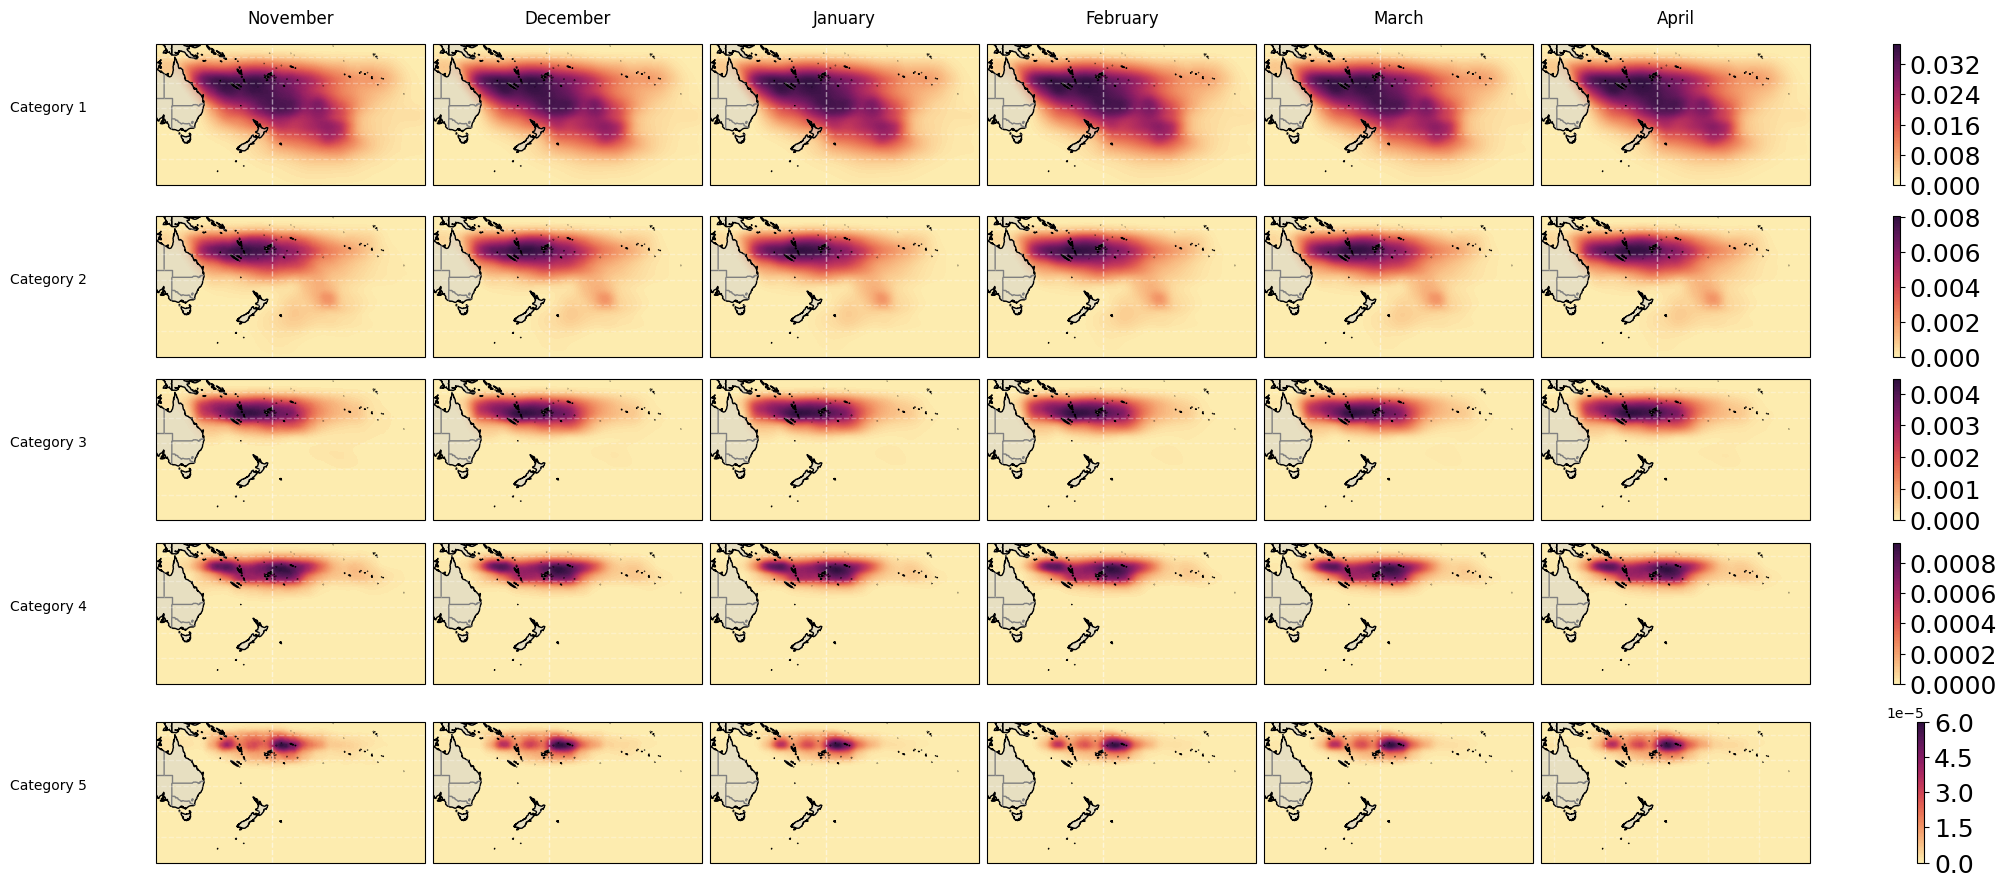

In [96]:
# make map of output variance
make_years_to_relative_error_threshold_figure(np.ones(var.shape), np.flipud(var), 1)

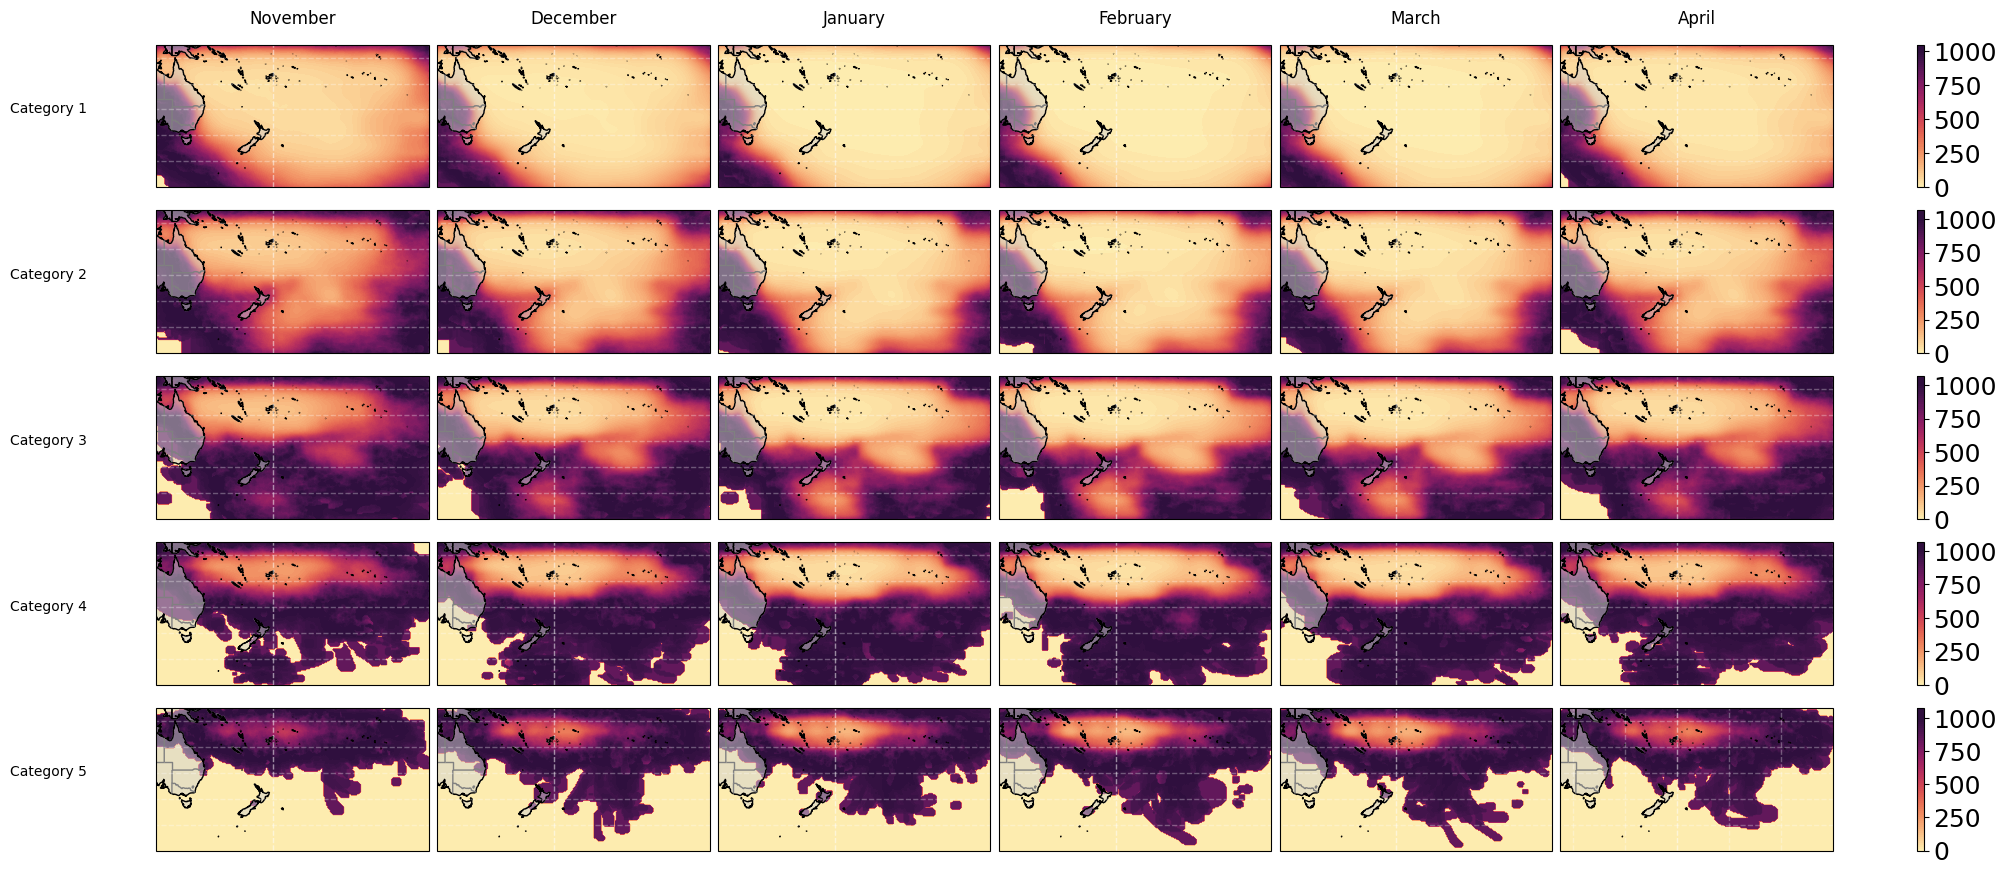

In [7]:
make_years_to_relative_error_threshold_figure(np.flipud(var), np.flipud(loss), 1)

In [8]:
print(loss.shape)

(110, 210, 6, 6)


In [36]:
loss_3_5_sum = np.flipud(np.sum(loss[:,:,:,3:], axis=(2, 3))/1000)
var_3_5_sum = np.flipud(np.sum(var[:,:,:,3:], axis=(2,3)))

In [12]:
print(loss_3_5_sum.shape)

(110, 210)


In [25]:
adjusted_variance = np.flipud(var_3_5_sum) - np.flipud(loss_3_5_sum)


In [81]:
import pandas as pd

EXAMPLE_HOSPITALS = [{
    "name": "Vaiola",
    "coordinates": (-21.15515, 184.781183)
}, {
    "name": "Honiara National Referral Hospital",
    "coordinates": (-9.43531212, 159.96918117)
}, {
    "name": "Vila Central",
    "coordinates": (-17.7423312961028, 168.321078380767)
}]

df = pd.read_pickle("../Figures/AGU/histogram_data.pkl")



In [67]:
means_df = df.groupby(['Model', 'Hospital']).mean().reset_index()
means = means_df[means_df['Model'] == 'STORM']
storm_means = means['Mean Decadal Landfalls'].tolist()
storm_means[0], storm_means[1] = storm_means[1], storm_means[0]


[0.558040652090941, 0.14110568953238853, 0.7622845483020069]

In [70]:
len(df)

2214

In [82]:
import sys
sys.path.append("../")

from MachineLearning.Evaluation.evaluation_utils import (get_grid_cell)
new_variances = []
old_variances = []

## get what the adjusted variance should be for each hospital site
for i in range(3):
    hospital = EXAMPLE_HOSPITALS[i]
    cell = get_grid_cell(*EXAMPLE_HOSPITALS[i]["coordinates"], 0.5)
    new_variance = adjusted_variance[cell]
    new_variances.append(new_variance)
    old_variance = var_3_5_sum[cell]
    old_variances.append(old_variance)
        
    
new_variances = np.array(new_variances)
old_variances = np.array(old_variances)
storm_means = np.array(storm_means)

## compute the necessary adjustment factors, assuming that the distributions are approx. normal
scaling_factor = np.sqrt(new_variances / old_variances)
mean_adjustment = storm_means - scaling_factor * storm_means

print(scaling_factor, mean_adjustment)

n_examples_per_hospital = int(len(df) / len(EXAMPLE_HOSPITALS))
expanding_array = np.ones(n_examples_per_hospital)
expanded_scaling_factor = np.kron(scaling_factor, expanding_array)
expanded_mean_adjustment = np.kron(mean_adjustment, expanding_array)

adjusted_df = df.copy()
adjusted_df['Mean Decadal Landfalls'] = df['Mean Decadal Landfalls'] * expanded_scaling_factor + expanded_mean_adjustment


[0.98218149 0.92104874 0.98615866] [0.00994345 0.01114047 0.01055104]


In [83]:
print(df)

      Mean Decadal Landfalls      Hospital              Model
0                   0.559000        Vaiola              STORM
1                   0.548000        Vaiola              STORM
2                   0.572000        Vaiola              STORM
3                   0.556000        Vaiola              STORM
4                   0.552000        Vaiola              STORM
...                      ...           ...                ...
2209                0.723528  Vila Central  FNO N=100 Decades
2210                0.721934  Vila Central  FNO N=100 Decades
2211                0.745077  Vila Central  FNO N=100 Decades
2212                0.745103  Vila Central  FNO N=100 Decades
2213                0.726677  Vila Central  FNO N=100 Decades

[2214 rows x 3 columns]


In [103]:
import seaborn as sns
def make_example_site_histogram_figures(df, save_path=None):

    n_examples = len(EXAMPLE_HOSPITALS)
    fig, axes = plt.subplots(1, n_examples, figsize=(20,15), layout="compressed")
    
    ## how to plot the data
    g = sns.displot(data=df,
                    col='Hospital',
                    hue='Model',
                    x='Mean Decadal Landfalls',
                    element='step', 
                    common_bins=False,
                    common_norm=False,
                    facet_kws={'sharex': False}
                   )
    fig = g.fig

    if save_path is not None:
        fig.savefig(save_path)        

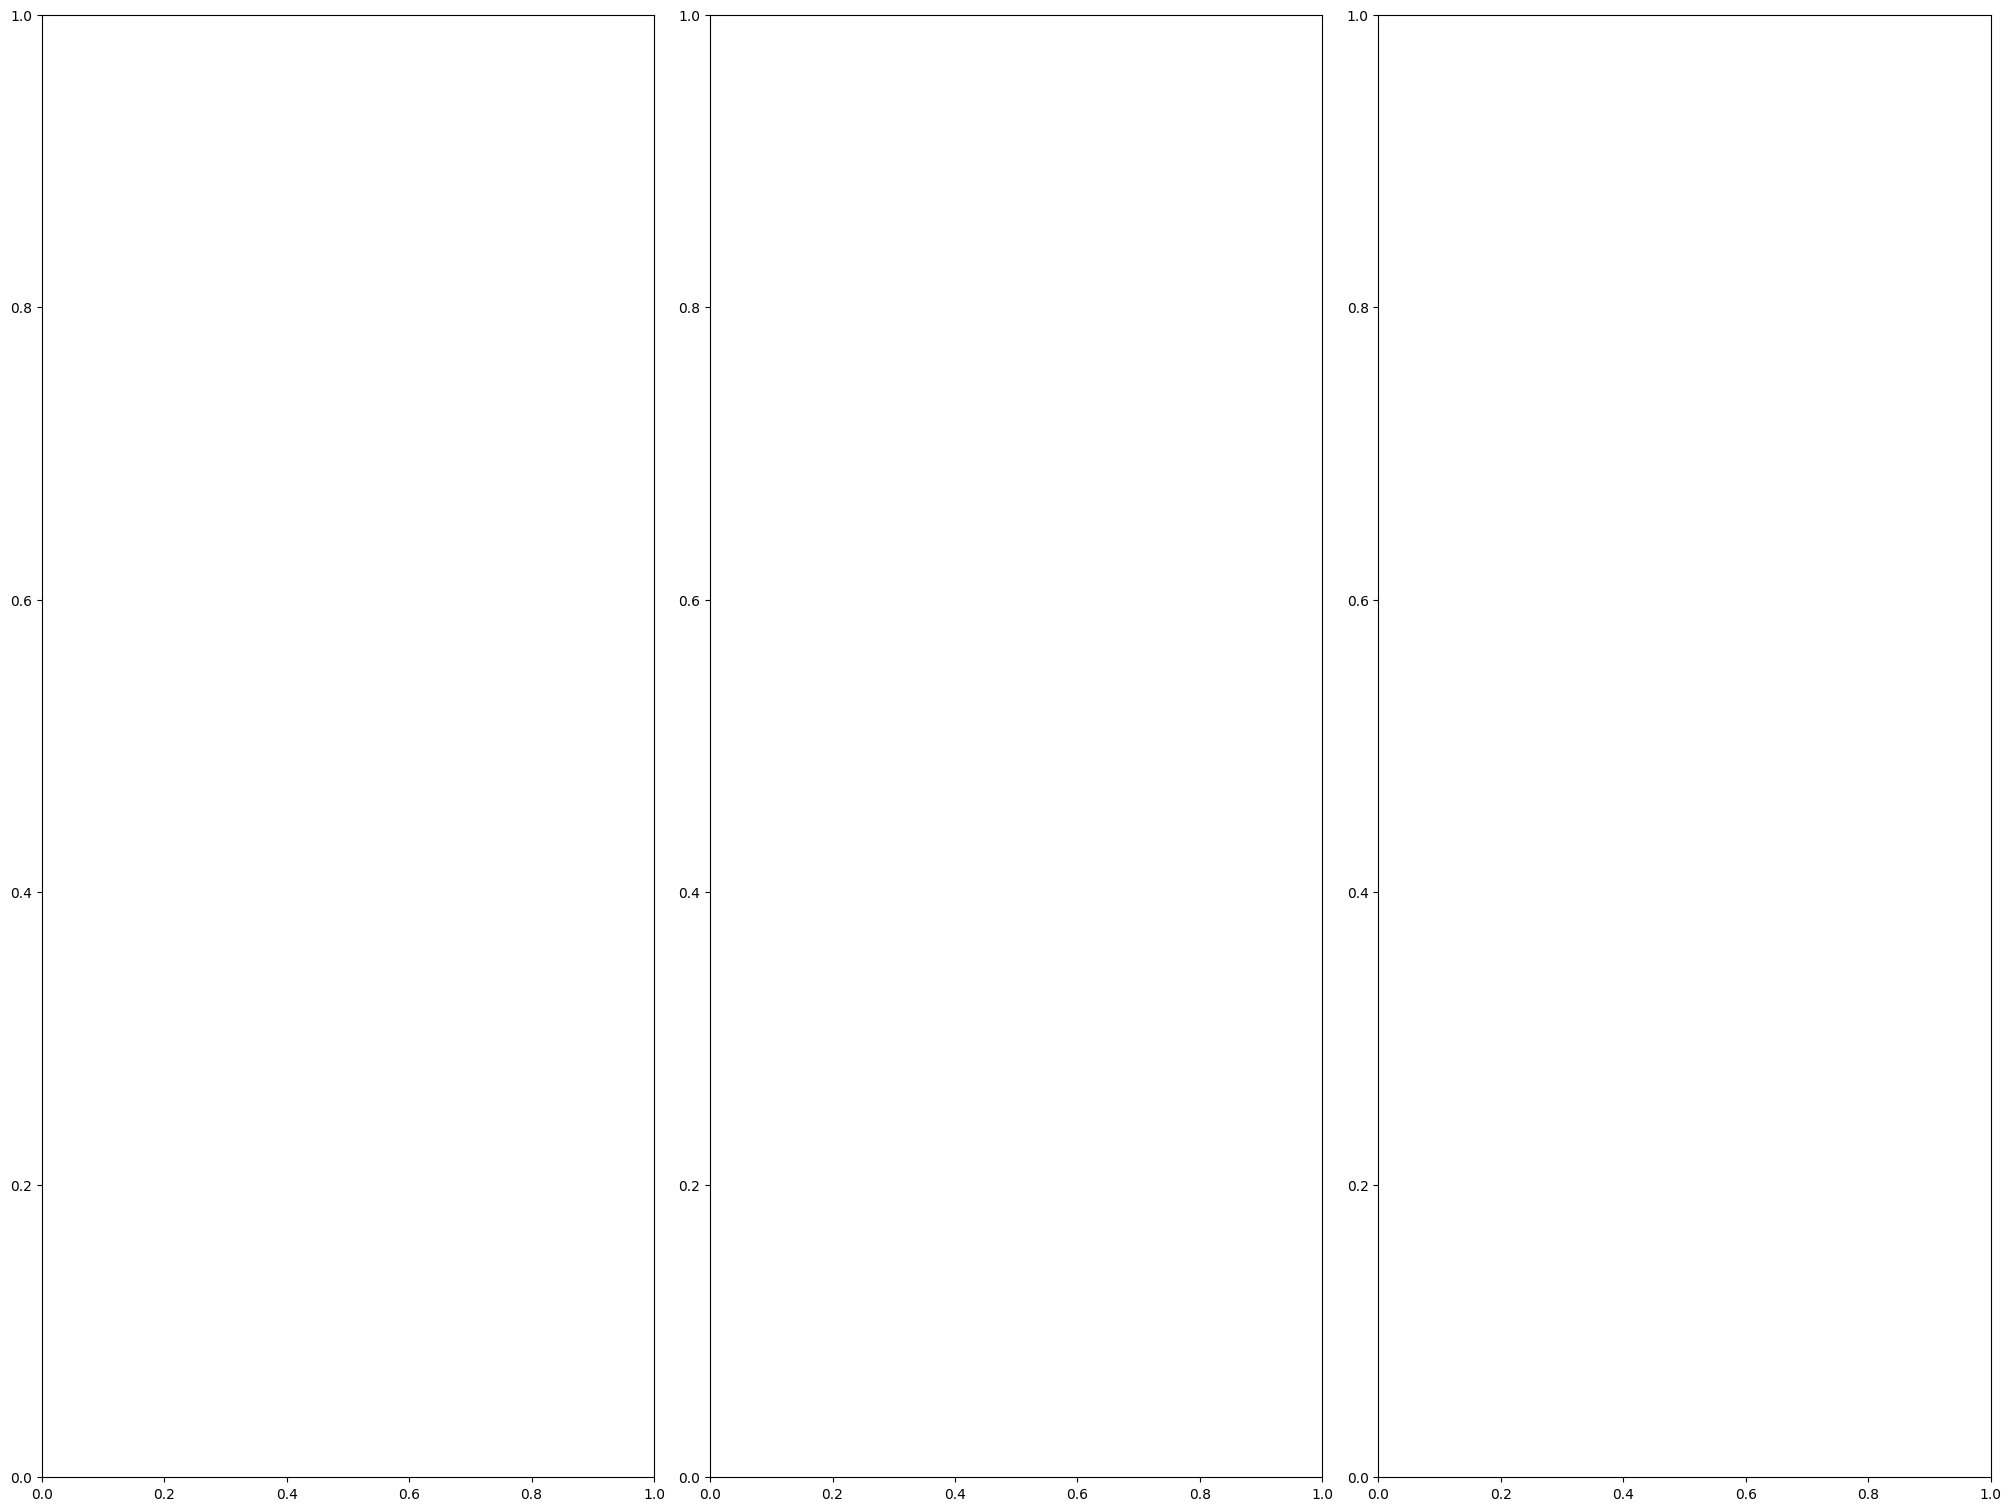

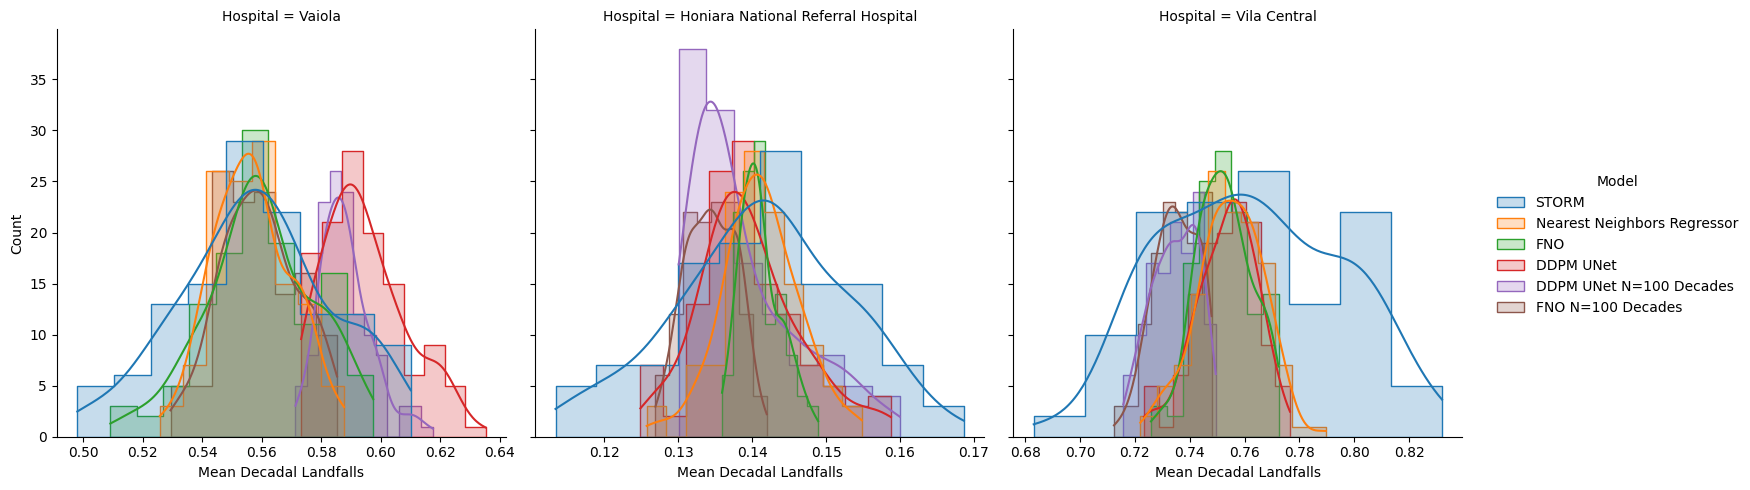

In [93]:
make_example_site_histogram_figures(adjusted_df)

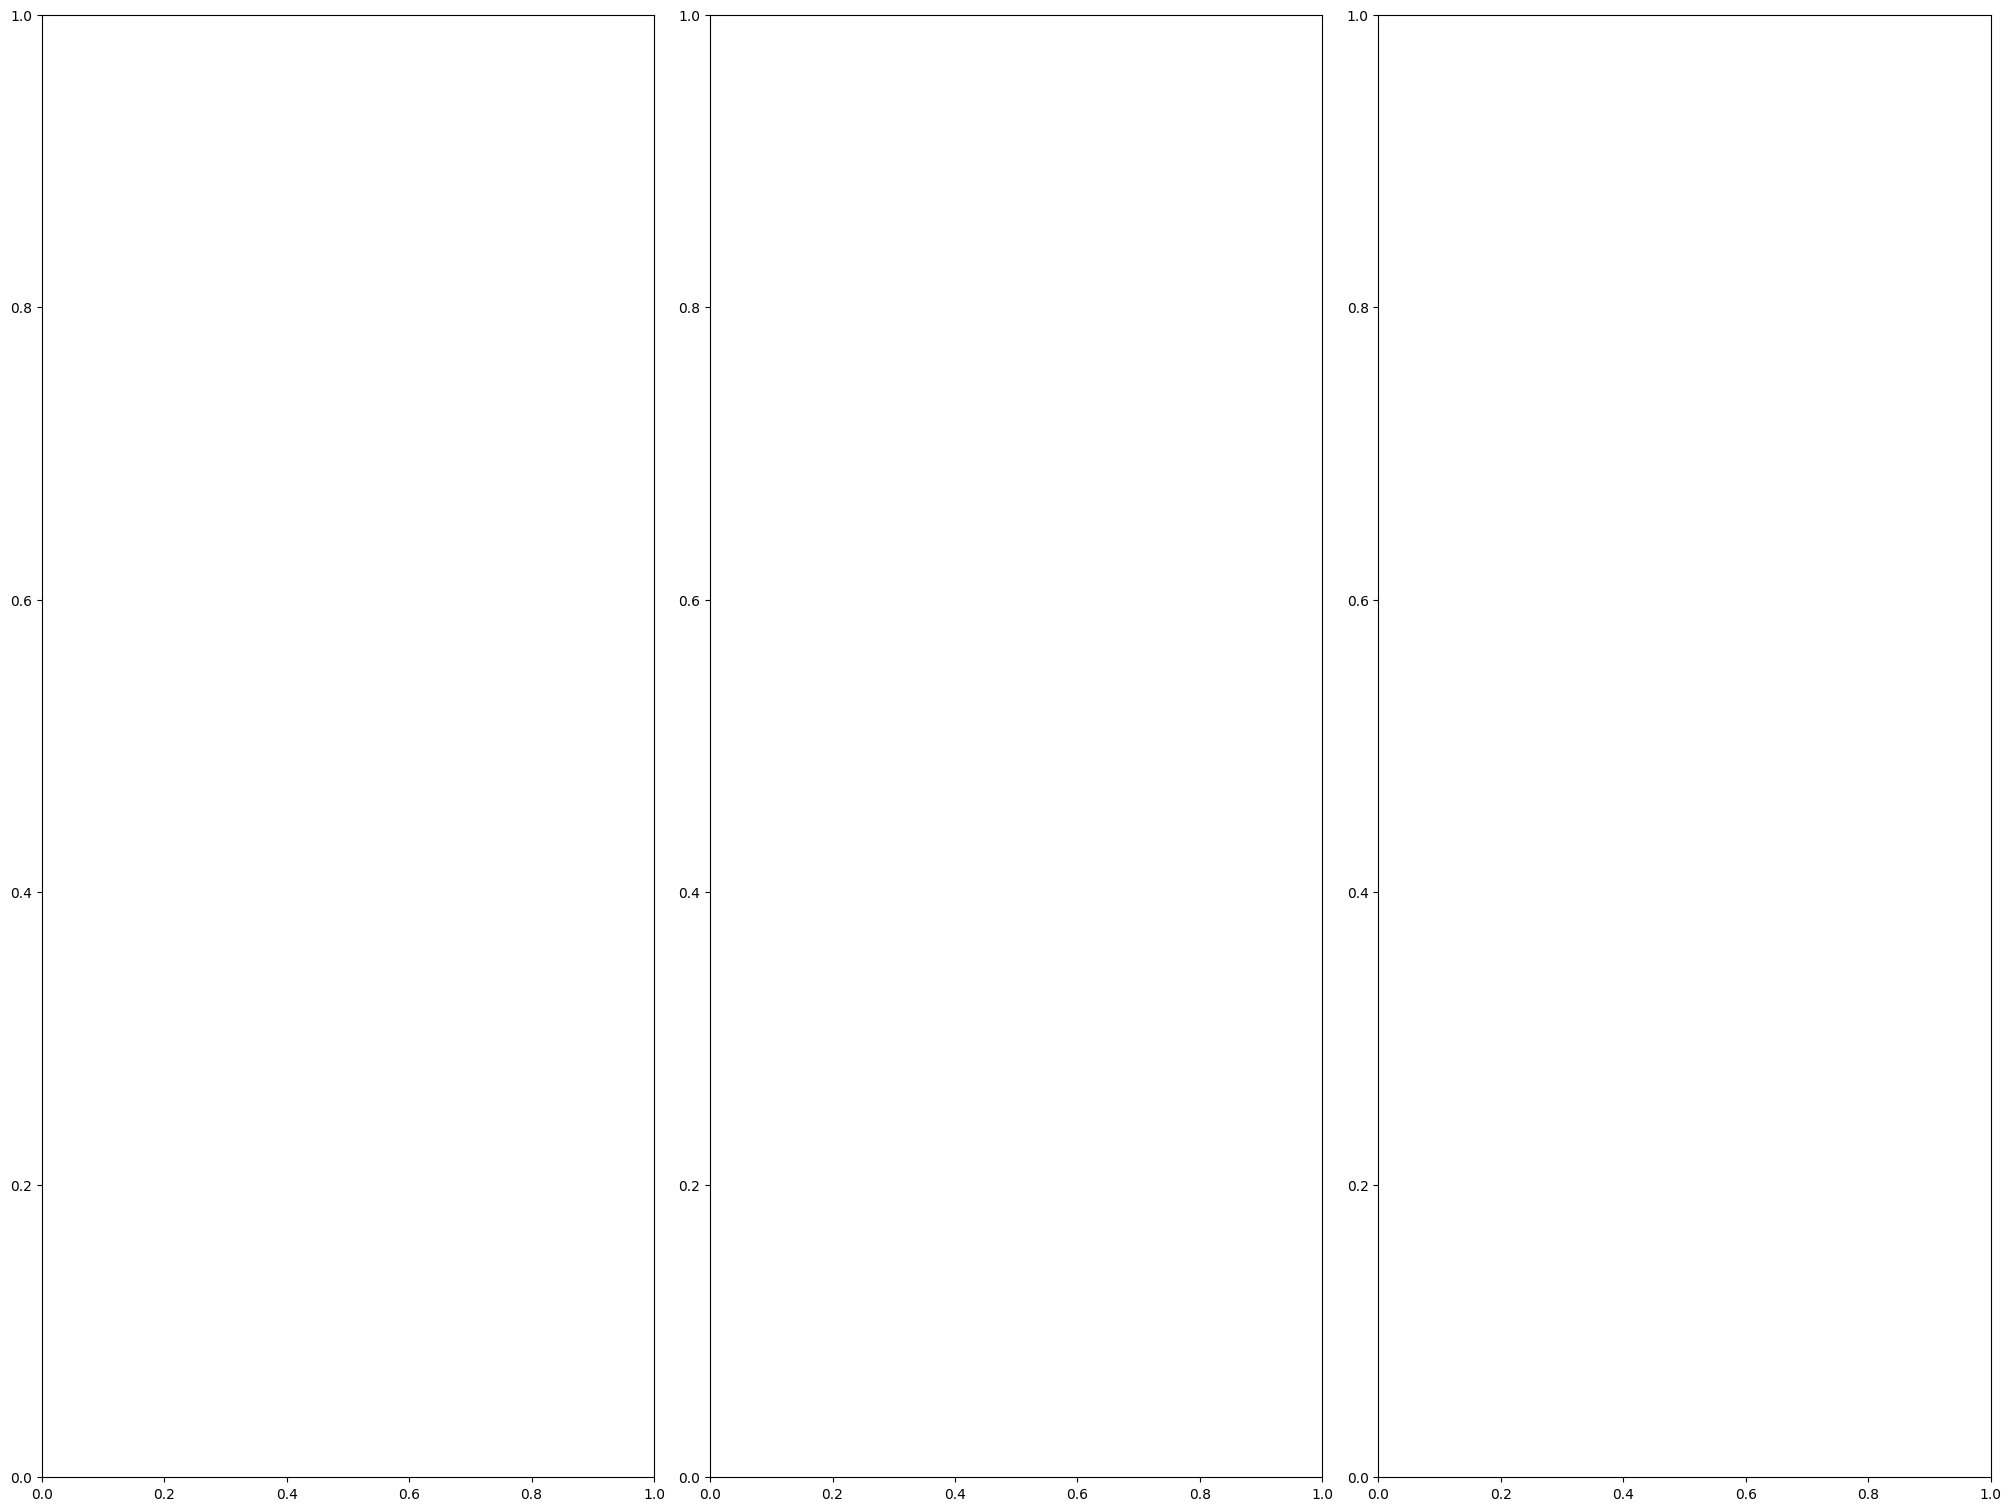

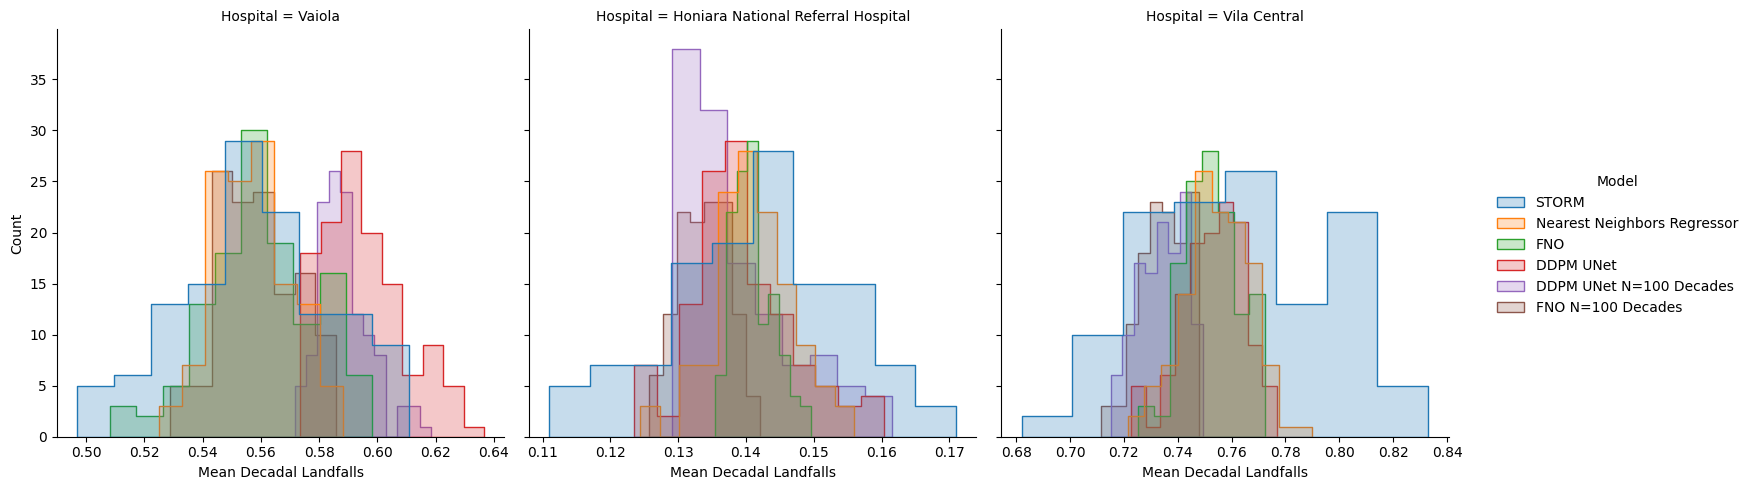

In [104]:
make_example_site_histogram_figures(df)

In [73]:
b = np.arange(5)

In [74]:
np.kron(a, b)

array([0., 1., 2., 3., 4., 0., 1., 2., 3., 4., 0., 1., 2., 3., 4.])

In [75]:
np.kron(b, a)

array([0., 0., 0., 1., 1., 1., 2., 2., 2., 3., 3., 3., 4., 4., 4.])

In [102]:
print(df.groupby(['Hospital', 'Model']).mean().to_latex())

\begin{tabular}{llr}
\toprule
 &  & Mean Decadal Landfalls \\
Hospital & Model &  \\
\midrule
\multirow[t]{6}{*}{Honiara National Referral Hospital} & DDPM UNet & 0.139392 \\
 & DDPM UNet N=100 Decades & 0.138727 \\
 & FNO & 0.141087 \\
 & FNO N=100 Decades & 0.133858 \\
 & Nearest Neighbors Regressor & 0.141099 \\
 & STORM & 0.141106 \\
\cline{1-3}
\multirow[t]{6}{*}{Vaiola} & DDPM UNet & 0.595293 \\
 & DDPM UNet N=100 Decades & 0.588602 \\
 & FNO & 0.559434 \\
 & FNO N=100 Decades & 0.559379 \\
 & Nearest Neighbors Regressor & 0.556820 \\
 & STORM & 0.558041 \\
\cline{1-3}
\multirow[t]{6}{*}{Vila Central} & DDPM UNet & 0.753268 \\
 & DDPM UNet N=100 Decades & 0.734179 \\
 & FNO & 0.752447 \\
 & FNO N=100 Decades & 0.734618 \\
 & Nearest Neighbors Regressor & 0.754641 \\
 & STORM & 0.762285 \\
\cline{1-3}
\bottomrule
\end{tabular}



In [98]:
print(means_df)

                          Model                            Hospital  \
0                     DDPM UNet  Honiara National Referral Hospital   
1                     DDPM UNet                              Vaiola   
2                     DDPM UNet                        Vila Central   
3       DDPM UNet N=100 Decades  Honiara National Referral Hospital   
4       DDPM UNet N=100 Decades                              Vaiola   
5       DDPM UNet N=100 Decades                        Vila Central   
6                           FNO  Honiara National Referral Hospital   
7                           FNO                              Vaiola   
8                           FNO                        Vila Central   
9             FNO N=100 Decades  Honiara National Referral Hospital   
10            FNO N=100 Decades                              Vaiola   
11            FNO N=100 Decades                        Vila Central   
12  Nearest Neighbors Regressor  Honiara National Referral Hospital   
13  Ne

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:

import numpy as np
import os
import sys
import xarray as xr

sys.path.append("../")
from  STORM.preprocessing import extract_data


#data=xr.open_dataset('../STORM/IBTrACS.since1980.v04r01.nc',decode_times=False)
#extract_data(data, save_path="/oscar/home/ewinkelm/EMPIRIC_AI_emulation/STORM")
#data.close()


/oscar/home/ewinkelm/.conda/envs/data_env/lib/python3.9/site-packages


In [5]:
latlist = np.load("../STORM/LATLIST_INTERP.npy", allow_pickle=True).item()
lonlist = np.load("../STORM/LONLIST_INTERP.npy", allow_pickle=True).item()
windlist = np.load("../STORM/WINDLIST_INTERP.npy", allow_pickle=True).item()
rmaxlist = np.load("../STORM/RMAXLIST_INTERP.npy", allow_pickle=True).item()
yearlist = np.load("../STORM/YEARLIST_INTERP.npy", allow_pickle=True).item()
monthlist = np.load("../STORM/MONTHLIST_INTERP.npy", allow_pickle=True).item()

In [6]:

data = {"lat": [], "lon": [], "wind": []}

for storm_index in latlist.keys():
    if storm_index > 2: break
    lats = latlist[storm_index]
    if len(lats) == 0: continue
    lons = lonlist[storm_index]
    winds = windlist[storm_index]
    
    winds = list(np.nan_to_num(winds))
    #print(list(rmaxs.items())[:5])
    
    data["lat"] += lats
    data["lon"] += lons
    data["wind"] += winds
        

print(len(data["lat"]))


28


         lat         lon       rmax  storm_index
0      -12.0  173.500000   0.000000            0
1      -12.2  173.699997   0.000000            0
2      -12.5  173.899994   0.000000            0
3      -12.7  174.199997   0.000000            0
4      -13.0  174.399994   0.000000            0
...      ...         ...        ...          ...
116183   8.2  110.900002  37.040001         4036
116184   8.1  110.300003  33.335999         4036
116185   8.1  109.800003  27.780001         4036
116186   8.1  109.300003  37.040001         4036
116187   8.2  108.800003  46.299999         4036

[116188 rows x 4 columns]


In [234]:

from matplotlib.collections import LineCollection
import cmocean

def colored_lines(xs, ys, cs, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt",'transform': ccrs.PlateCarree()}
    default_kwargs.update(lc_kwargs)

    all_segments = []
    all_cs = []
    for i in range(len(xs)):
        x = xs[i]
        if len(x) == 0: continue
        y = ys[i]
        c = cs[i]
        all_cs.append(c)
        # Compute the midpoints of the line segments. Include the first and last points
        # twice so we don't need any special syntax later to handle them.
        x = np.asarray(x)
        y = np.asarray(y)
    
        x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
        y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
    
        # Determine the start, middle, and end coordinate pair of each line segment.
        # Use the reshape to add an extra dimension so each pair of points is in its
        # own list. Then concatenate them to create:
        # [
        #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
        #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
        #   ...
        # ]
        coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
        coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
        coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
        segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)
        all_segments.append(segments)
    all_segments = np.concatenate(all_segments, axis=0)
    all_cs = np.concatenate(all_cs, axis=0)
    print(np.max(all_cs))
    lc = LineCollection(all_segments, **default_kwargs)
    lc.set_array(all_cs)  # set the colors of each segment

    return ax.add_collection(lc)
    
def plot_IBTrACS(latlist, lonlist, windlist):

    fig, axes = plt.subplots(1, figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)

    
    ax = axes
    ax.add_feature(land_feature)
    ax.add_feature(countries_feature)
    ax.add_feature(states_provinces, edgecolor='gray')

    ax.set_xticks([])
    ax.set_yticks([])


    # Plot gradient for model prediction on top of the land feature
    ##lonplot2 = np.linspace(135, 240, val.shape[1])
    #latplot2 = np.linspace(-5, -60, val.shape[0])
    
    # Use a continuous colormap
    #pc[category-1][month] = ax.contourf(lonplot2, latplot2, val, levels=100, cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())
    #print(ibtracs_df["lat"].tolist())

    lines = colored_lines(list(lonlist.values()), list(latlist.values()), list(windlist.values()), ax, linewidth=5, cmap=cmocean.cm.thermal)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='white', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.colorbar(lines)
    ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())
        
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.show()
    

83.75154876708984


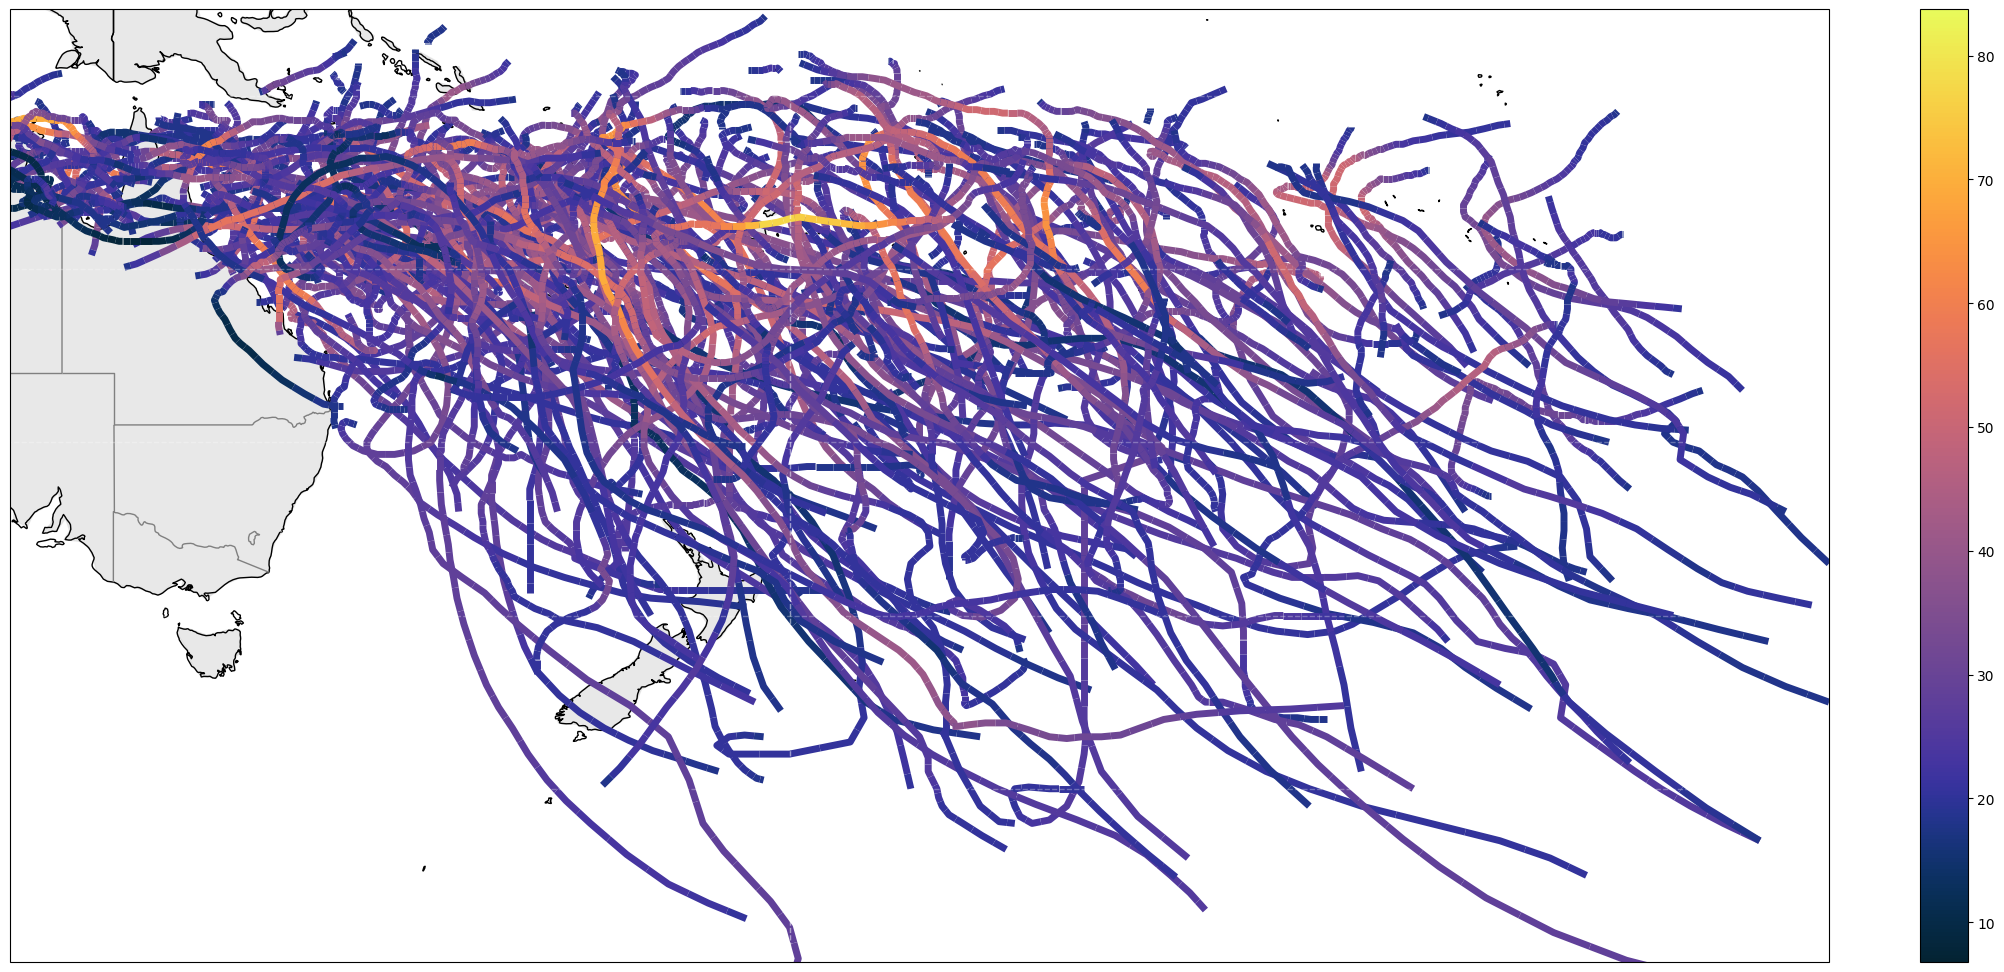

In [235]:
#list(latlist.values())
plot_IBTrACS(latlist, lonlist, windlist)

In [7]:
from STORM.SAMPLE_TC_PRESSURE import TC_Category
from TrainingDataGeneration.RiskFactors import get_landfalls_data
def create_TC_data(latlist, lonlist, windlist, rmaxlist, yearlist, monthlist):
    """data format [( 
        year,
        month,
        storm_number,
        l,
        idx,
        lat (one step),
        lon (one),
        pressure (one),
        wind (one),
        storm_radius_max_wind_speeds (one),
        category,
        landfall (one),
        distance)]
    """
    TC_data = []
    
    for storm_index in range(len(latlist.keys())):
        lats = latlist[storm_index]
        if len(lats) == 0: continue
        lons = lonlist[storm_index]
        winds = windlist[storm_index]
        rmaxs = rmaxlist[storm_index]
        
        if np.isnan(np.min(rmaxs)): rmaxs = [46.29999923706055] * len(lats)
        
        
        year = yearlist[storm_index][0] - 1979
        month = monthlist[storm_index][0]
        if month not in [1, 2, 3, 4, 11, 12]: continue
        
        for i in range(len(lats)):
            TC_data.append(
                [year,
                 month,
                 storm_index,
                 i,
                 i,
                 lats[i],
                 lons[i],
                 0,
                 winds[i],
                 rmaxs[i],
                 TC_Category(winds[i]),
                 0,
                 0
                ])
    
    return TC_data

In [8]:
TC_data = create_TC_data(latlist, lonlist, windlist, rmaxlist, yearlist, monthlist)

means, stds = get_landfalls_data(TC_data,
        "SP",
        4,
        0.5,
        False,
        storm_rmax_multiple=4
)


In [9]:
mean_decadal = np.flipud(np.sum(means[:, :, :, 3:], axis=(-2,-1)))

In [21]:
def plot_map_data(data):
    
    fig, axes = plt.subplots(1, 1, figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)


    ax = axes
    ax.add_feature(land_feature)
    ax.add_feature(countries_feature)
    ax.add_feature(states_provinces, edgecolor='gray')

    ax.set_xticks([])
    ax.set_yticks([])


    # Plot gradient for model prediction on top of the land feature
    lonplot2 = np.linspace(135, 240, data.shape[1])
    latplot2 = np.linspace(-5, -60, data.shape[0])
            
    # Use a continuous colormap
    c = ax.contourf(lonplot2, latplot2, data, levels=100, cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())
            
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())

        
    gl.xlocator = mticker.FixedLocator([-180, -160, -140, -90, -45, 0, 45, 90, 140, 160, 180, 225, 270, 315, 360])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
            
    # Adjust map extent to focus on the region of interest
    
    cbar = fig.colorbar(c, ax=ax)
    nbins = 5
    tick_locator = mticker.MaxNLocator(nbins=nbins)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=18)
    
    plt.show()


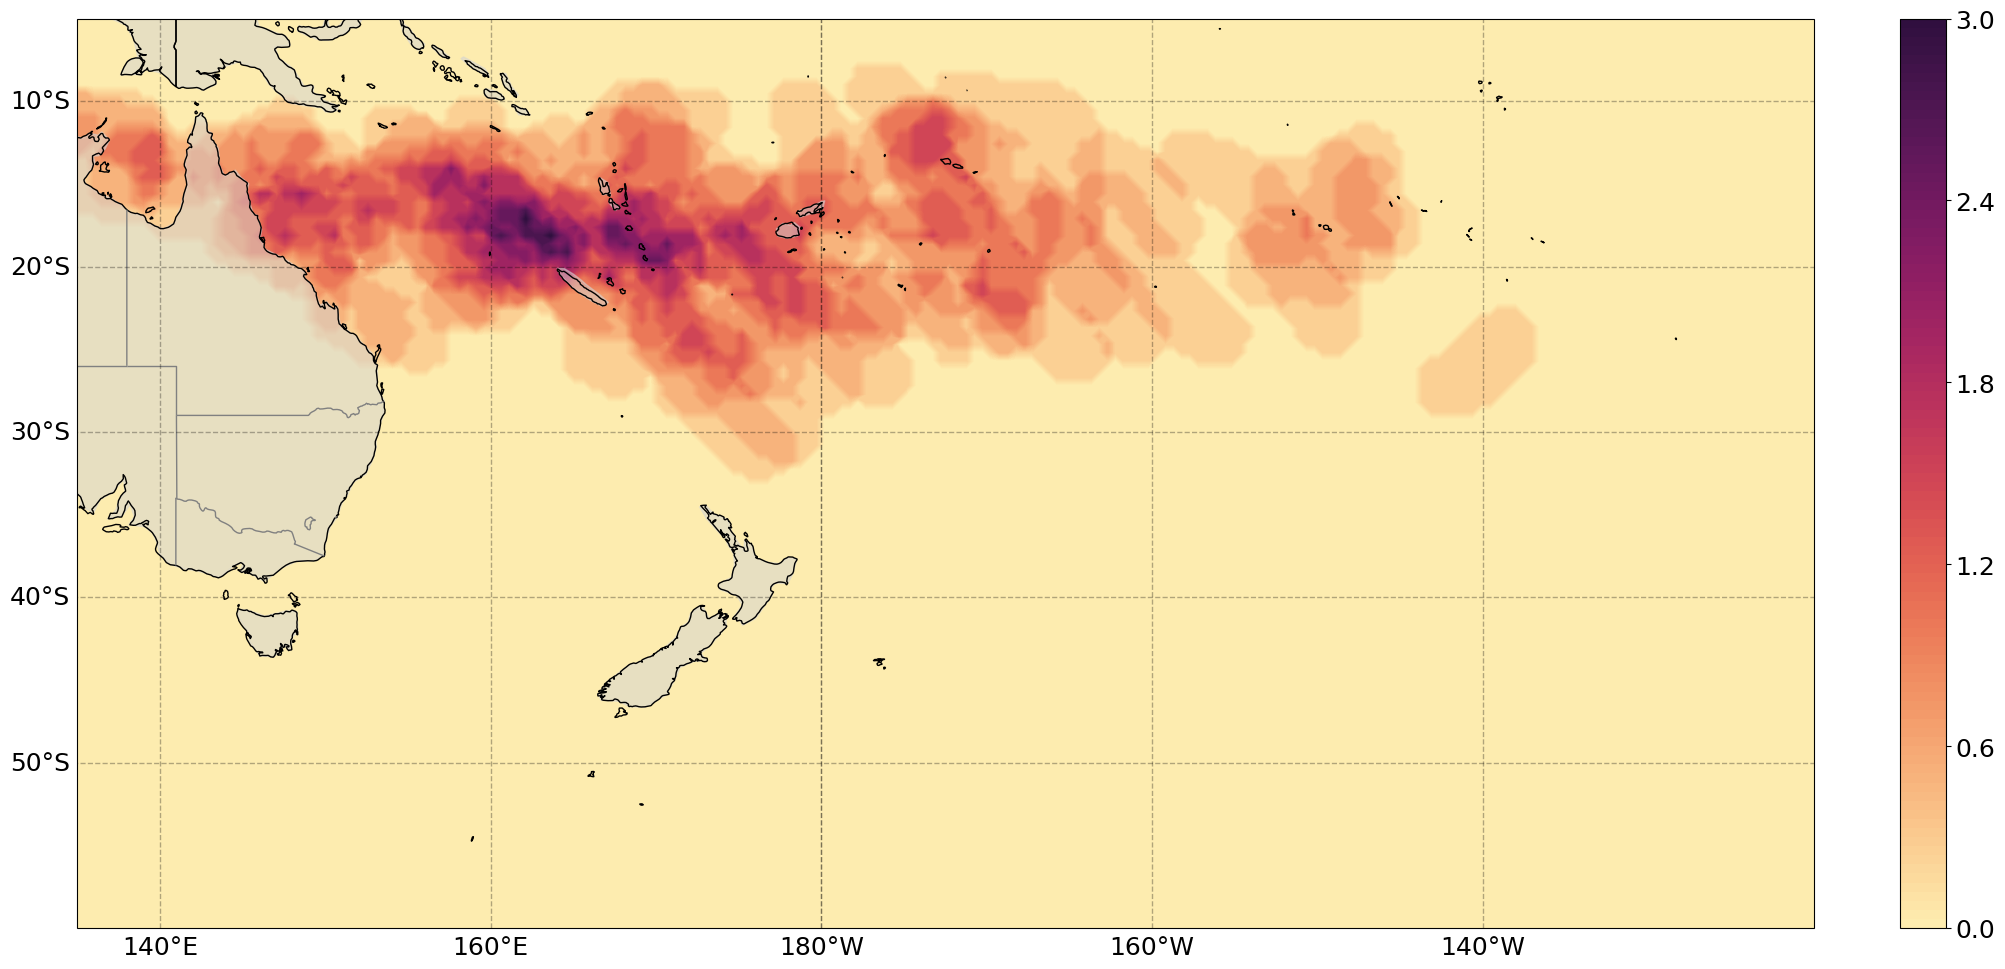

In [22]:
plot_map_data(mean_decadal)

In [96]:
rmax_median = np.nanmedian(np.concatenate(list(rmaxlist.values()), axis=0))
print(rmax_median)

46.29999923706055
